# Your Best Choice of Airbnb in Seattle
### I am planning a trip to Seattle for 3 days and want to book a nice place from Airbnb with a reasonable price. Here is what I am doing using Airbnb data retrieved online *(http://insideairbnb.com/get-the-data.html)*. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import folium # map rendering library
%matplotlib inline

### Load data 

In [2]:
# downLoad online data file
!wget -O listings.csv http://data.insideairbnb.com/united-states/wa/seattle/2020-04-23/visualisations/listings.csv
!wget -O reviews.csv.gz http://data.insideairbnb.com/united-states/wa/seattle/2020-04-23/data/reviews.csv.gz    

--2020-06-06 00:14:11--  http://data.insideairbnb.com/united-states/wa/seattle/2020-04-23/visualisations/listings.csv
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.207.194
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.207.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1127379 (1.1M) [application/csv]
Saving to: ‘listings.csv’

listings.csv        100%[===================>]   1.07M  4.96MB/s    in 0.2s    

2020-06-06 00:14:12 (4.96 MB/s) - ‘listings.csv’ saved [1127379/1127379]

--2020-06-06 00:14:12--  http://data.insideairbnb.com/united-states/wa/seattle/2020-04-23/data/reviews.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.207.194
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.207.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43997555 (42M) [application/x-gzip]
Saving to: ‘reviews.csv.gz’

reviews.csv.gz      100%[===================>]  

In [3]:
# Load listing data into dataframe
list = pd.read_csv('./listings.csv')
list.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2318,Casa Madrona - Urban Oasis 1 block from the park!,2536,Megan,Central Area,Madrona,47.61082,-122.29082,Entire home/apt,296,7,32,2020-02-01,0.23,2,90
1,6606,"Fab, private seattle urban cottage!",14942,Joyce,Other neighborhoods,Wallingford,47.65411,-122.33761,Entire home/apt,90,30,150,2019-09-28,1.14,3,82
2,9419,Glorious sun room w/ memory foambed,30559,Angielena,Other neighborhoods,Georgetown,47.55017,-122.31937,Private room,62,2,148,2019-12-27,1.25,8,364
3,9531,The Adorable Sweet Orange Craftsman,31481,Cassie,West Seattle,Fairmount Park,47.55539,-122.38474,Entire home/apt,165,3,40,2019-12-30,0.40,2,365
4,9534,The Coolest Tangerine Dream MIL!,31481,Cassie,West Seattle,Fairmount Park,47.55624,-122.38598,Entire home/apt,125,2,49,2020-02-29,0.49,2,350


In [4]:
# Check list columns and data types
list.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [5]:
# Check if column "id" is unique
list.shape[0]==list['id'].unique().shape[0]

True

In [6]:
# Check the pertentage of NaN numbers in the data set
np.sum(list.isna())/list.shape[0]

id                                0.00000
name                              0.00000
host_id                           0.00000
host_name                         0.00000
neighbourhood_group               0.00000
neighbourhood                     0.00000
latitude                          0.00000
longitude                         0.00000
room_type                         0.00000
price                             0.00000
minimum_nights                    0.00000
number_of_reviews                 0.00000
last_review                       0.12823
reviews_per_month                 0.12823
calculated_host_listings_count    0.00000
availability_365                  0.00000
dtype: float64

##### Only 13% of rental listing has no data in "last_review" and "reviews_per_month".

### Q1: Is there an area in Seattle where there are more choices of rentals with relatively lower price? 
##### Now let's look at the number of listings and mean price in each neighbourhood

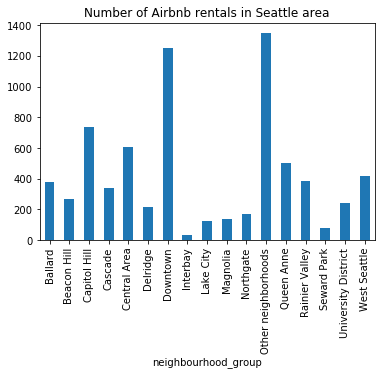

In [7]:
# get the number of listing in each neighbourhood
num_list = list[['id','neighbourhood_group']].groupby('neighbourhood_group').count() 
num_list['id'].plot(kind="bar");
plt.title("Number of Airbnb rentals in Seattle area");

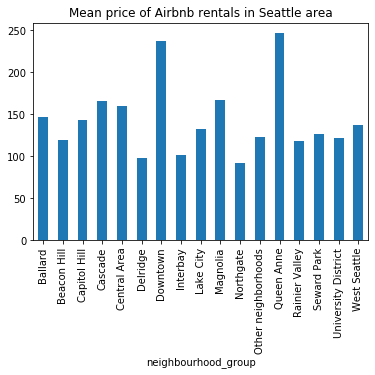

In [8]:
# get the number of listing in each neighbourhood
price_mean = list[['price','neighbourhood_group']].groupby('neighbourhood_group').mean()
price_mean['price'].plot(kind="bar");
plt.title("Mean price of Airbnb rentals in Seattle area");

##### The most expensive Airbnb rentals are in Queen Anne and downtown area. Downtown area also has the second most number of rentals, only less that "other neighbourhoods" which actually is the collection of unsorted data.

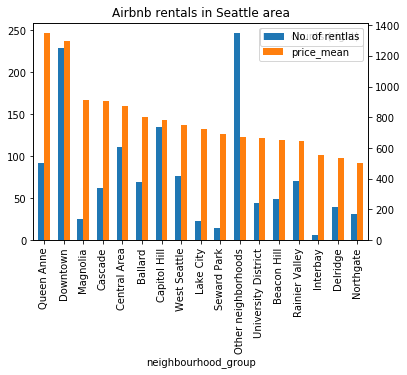

In [9]:
# Sort data by number of lisitng in each area and plot together with mean_price
df_area=num_list
df_area['price_mean']=price_mean['price']
df_area.rename(columns={"id": "counts"},inplace=True)
df_area.sort_values(by='price_mean',ascending=False,inplace=True)
df_area[['counts','price_mean']].plot(kind="bar",secondary_y= 'counts',width=0.6);
plt.title("Airbnb rentals in Seattle area");
plt.legend(['No. of rentlas','mean price']);

#### Capitol Hill seems to be a good area with more rentals and mean price less than $150

### Q2: Which Seattle area rentals have good reviews in recent two years?

In [10]:
# Load review data into dataframe
review = pd.read_csv('reviews.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2318,146,2008-09-15,2451,Kevin,1000 times better than staying at a hotel.
1,2318,126302712,2017-01-10,12332845,Jessica,"Our family (two couples, a two year old and an..."
2,2318,140977084,2017-04-01,4789466,Ivan,Top of the list locations we have stayed at! T...
3,2318,147262504,2017-04-25,55817131,Mike,"SUCH an awesome place. Very clean, quiet and s..."
4,2318,161806368,2017-06-18,113604590,Pete,We flew quite a distance to be at our only dau...


In [11]:
# Check the pertentage of NaN numbers in the data set
np.sum(review.isna())/review.shape[0]

listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
comments         0.000455
dtype: float64

In [12]:
# drop rows without comments
review.dropna(inplace=True)
review.shape

(397976, 6)

In [13]:
# Get the review list which only containing good reviews in 2018~2020
words='good|better|best|excellent|perfect|wonderful|unique|great|awesome|nice|pretty|stylish|cute|fabulous \
|spacious|comfortable|comfy|convenient|top|clean|love|like|thank|Thank|appreciat|recommend|friendly|helpful'
years='2018|2019|2020'
review_good=review.loc[(review['comments'].str.contains(words) & review['date'].str.contains(years)),['listing_id','id','date']]
review_good.shape

(212962, 3)

In [14]:
# Calculate the pertentage of good review among all reviews
review_good.shape[0]/review.shape[0]

0.5351126701107605

### merge two tables: list and review

In [15]:
# Now I'll merge two data sets review_good and list by id
rental_good=pd.merge(left=review_good['listing_id'], right=list['id'], left_on='listing_id', right_on='id')
# Sort the dataset by counts of good reviews
rental_good=rental_good.groupby('listing_id').count().reset_index()
rental_good.rename(columns={'id':'good_review_counts'},inplace=True)
rental_good.sort_values(by='good_review_counts',ascending=False,inplace=True)
print('There are ', rental_good.shape[0], 'rental listings that have good reveiws')
rental_good.head()

There are  5686 rental listings that have good reveiws


,listing_id,good_review_counts
1213,11398085,375
1328,12609601,333
468,3861673,299
679,6078397,298
616,5241773,268


In [16]:
# Add more information from list to the dataset
features=['id','name','neighbourhood_group','neighbourhood','latitude','longitude','room_type','price', \
                   'minimum_nights','number_of_reviews','last_review','reviews_per_month', \
                   'calculated_host_listings_count','availability_365']
rental_good=pd.merge(left=rental_good, right=list[features], left_on='listing_id', right_on='id')
rental_good.drop(columns='id',inplace=True)
rental_good.head(3)

,listing_id,good_review_counts,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,11398085,375,Cottage in the Heart of the City,Interbay,Interbay,47.63742,-122.38680,Entire home/apt,89,1,709,2020-03-19,14.66,1,188
1,12609601,333,Cozy basement suite with large patio & HOT TUB,Northgate,Maple Leaf,47.69537,-122.31758,Entire home/apt,100,1,421,2020-03-21,13.52,1,81
2,3861673,299,Beautiful Guest Suite for 2 in Ballard,Ballard,Whittier Heights,47.68403,-122.37409,Entire home/apt,70,7,836,2020-03-14,12.14,1,249


In [17]:
rental_good['room_type'].unique()
rental_good.head()

,listing_id,good_review_counts,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,11398085,375,Cottage in the Heart of the City,Interbay,Interbay,47.63742,-122.38680,Entire home/apt,89,1,709,2020-03-19,14.66,1,188
1,12609601,333,Cozy basement suite with large patio & HOT TUB,Northgate,Maple Leaf,47.69537,-122.31758,Entire home/apt,100,1,421,2020-03-21,13.52,1,81
2,3861673,299,Beautiful Guest Suite for 2 in Ballard,Ballard,Whittier Heights,47.68403,-122.37409,Entire home/apt,70,7,836,2020-03-14,12.14,1,249
3,6078397,298,Tiny House in Seattle,West Seattle,Genesee,47.56491,-122.39610,Entire home/apt,140,1,542,2020-04-17,11.69,1,328
4,5241773,268,"Cool/Fun House on Capitol Hill, Bdrm #2",Central Area,Minor,47.61243,-122.31590,Private room,89,1,594,2020-03-10,9.50,3,149


In [18]:
rental_good['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'],
      dtype=object)

In [19]:
# Encode "room_type" to number as the mapping in "cats"
ordered_room_type = ['Shared room', 'Private room', 'Hotel room', 'Entire home/apt']
cat_dtype = pd.api.types.CategoricalDtype(categories=ordered_room_type, ordered=True)
rental_good['room_type_cat'] = rental_good['room_type'].astype(cat_dtype).cat.codes
rental_good.head()

,listing_id,good_review_counts,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,room_type_cat
0,11398085,375,Cottage in the Heart of the City,Interbay,Interbay,47.63742,-122.38680,Entire home/apt,89,1,709,2020-03-19,14.66,1,188,3
1,12609601,333,Cozy basement suite with large patio & HOT TUB,Northgate,Maple Leaf,47.69537,-122.31758,Entire home/apt,100,1,421,2020-03-21,13.52,1,81,3
2,3861673,299,Beautiful Guest Suite for 2 in Ballard,Ballard,Whittier Heights,47.68403,-122.37409,Entire home/apt,70,7,836,2020-03-14,12.14,1,249,3
3,6078397,298,Tiny House in Seattle,West Seattle,Genesee,47.56491,-122.39610,Entire home/apt,140,1,542,2020-04-17,11.69,1,328,3
4,5241773,268,"Cool/Fun House on Capitol Hill, Bdrm #2",Central Area,Minor,47.61243,-122.31590,Private room,89,1,594,2020-03-10,9.50,3,149,1


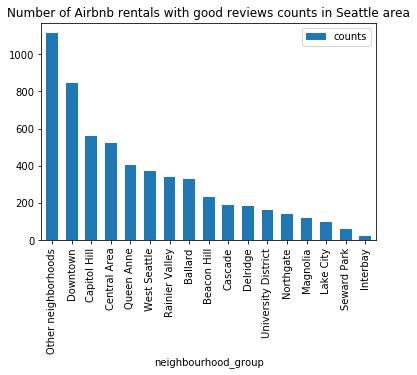

In [20]:
countByNei=rental_good[['listing_id','neighbourhood_group']].groupby('neighbourhood_group').count()
countByNei.rename(columns={'listing_id':'counts'},inplace=True)
countByNei.sort_values(by='counts',ascending=False, inplace=True)
ax=countByNei.plot(kind="bar",width=0.6);
ax.set_title("Number of Airbnb rentals with good reviews counts in Seattle area");

#### Besides "other neighborhoods", downtown area has the most number of good rentals, followed by capitol hill and central area.

### Q3. Which Airbnb is recommended in downtown Seattle?

##### I still want to stay in Seattle downtow although price is a bit higher. I will choose the rentals with more number of good review and relatively lower price. And it must have the following features:
- in downtown area
- hotel room or entire home/apartment
- minimum_nights < 4
- availability_365 > 180
- price < $350

In [21]:
features=['listing_id','name','good_review_counts','neighbourhood_group','price',
          'neighbourhood','latitude','longitude','room_type','minimum_nights']
rental_downtown=rental_good.loc[((rental_good['neighbourhood_group']=='Downtown') &
                             (rental_good['room_type_cat']>2) &
                             (rental_good['minimum_nights']<4) &
                             (rental_good['availability_365']>180) &
                             (rental_good['price']<350)) 
                                ,features]
rental_downtown.shape[0]

228

##### There are 228 rentals meets my criterias. Let me pick top 10 with most good reviews

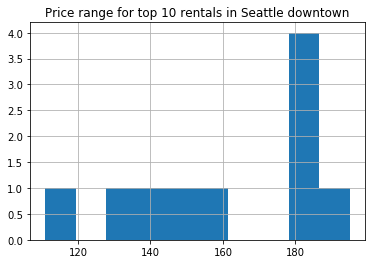

In [22]:
# Sort downtown rental by number of good reviews
rental_downtown.sort_values(by='good_review_counts',ascending=False,inplace=True)
# check the price range of top 20rental_downtown
ax=rental_downtown['price'].iloc[0:10].hist();
ax.set_title("Price range for top 10 rentals in Seattle downtown");

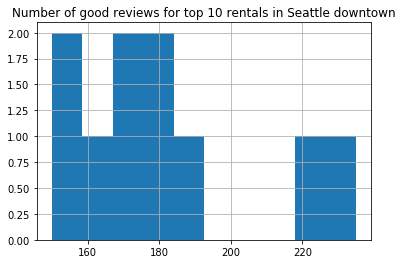

In [23]:
# check the number of good reviews
ax=rental_downtown['good_review_counts'].iloc[0:10].hist();
ax.set_title("Number of good reviews for top 10 rentals in Seattle downtown");

#### Their price is less than $200 with more than 100 good reviews. The all seems to be good choices. Below are the list of retals.

In [24]:
rental_downtown.head(10)

,listing_id,name,good_review_counts,neighbourhood_group,price,neighbourhood,latitude,longitude,room_type,minimum_nights
13,10125020,Historic loft in Pioneer Square,235,Downtown,180,Pioneer Square,47.60044,-122.33298,Entire home/apt,1
19,22958194,"Cruise ships, Gumwall & Pike Place Downtown Su...",225,Downtown,140,Pike-Market,47.60809,-122.34078,Entire home/apt,1
50,21077859,LEED Platinum Loft Near downtown/Capitol hill,191,Downtown,195,Yesler Terrace,47.60464,-122.32023,Entire home/apt,1
69,15927940,Climb into the Plush Bed to Doze at a Tranquil...,178,Downtown,111,First Hill,47.61310,-122.32374,Entire home/apt,1
70,16547797,"Pike, Walk-score 99, Loft, Live/visit Capitol ...",178,Downtown,150,First Hill,47.61342,-122.32189,Entire home/apt,1
77,19157420,"Center of Seattle, with Great City Views!!!",173,Downtown,129,Belltown,47.61337,-122.34393,Entire home/apt,1
83,16535510,"Spacious Studio, Heart of the City!!!",171,Downtown,160,Belltown,47.61344,-122.34399,Entire home/apt,1
106,22999858,Downtown Seattle w/ Large Kitchen and Bathroom,161,Downtown,183,Belltown,47.61363,-122.34448,Entire home/apt,1
121,7616008,Heart of Downtown Seattle,156,Downtown,183,Belltown,47.61337,-122.34389,Entire home/apt,1
145,3953742,"Lovely Historical Apartment, With Great Views!!!",150,Downtown,183,Belltown,47.61334,-122.34401,Entire home/apt,1


##### Let's find their locations on the map

In [68]:
# create map of Seattle downtown using latitude and longitude values
map_seattle_downtown = folium.Map(location=[47.6050, -122.3344], zoom_start=11)

# add blue markers for top 10 rentals to the map
for lat, lng, label in zip(rental_downtown['latitude'].iloc[0:10],
                           rental_downtown['longitude'].iloc[0:10],
                           rental_downtown['name'].iloc[0:10]):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle_downtown)

# add pop-up text to show the rental name
for lat, lng, label in zip(rental_downtown['latitude'].iloc[0:10],
                           rental_downtown['longitude'].iloc[0:10],
                           rental_downtown['name'].iloc[0:10]):
        folium.Marker([lat, lng], popup=label).add_to(map_seattle_downtown) 
        
map_seattle_downtown

### Q4: Are there any correlation between price and other features?

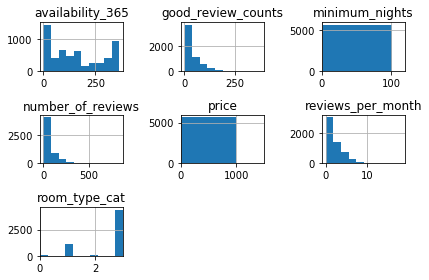

In [27]:
# Let's look at some statistical plots for rental_good
features=['price','good_review_counts','minimum_nights','number_of_reviews','availability_365','reviews_per_month','room_type_cat']
ax=rental_good[features].hist(bins=10);
ax[0,2].set_xlim((0,120));
ax[1,1].set_xlim((0,1500));
ax[2,0].set_xlim((0,3));
plt.tight_layout()

##### Most of the rentals provide entire home/apartment. The price, days available and minimum_nights vary in a large range. Features related to review have similar shape in histogram.

(7.0, 0.0)

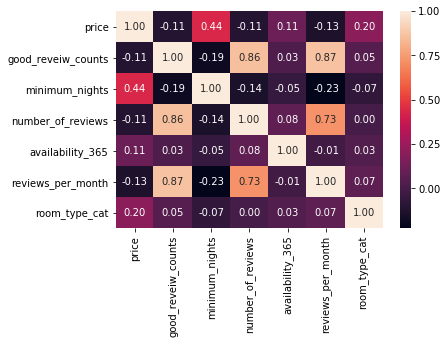

In [107]:
rental_good_num=rental_good[features]
ax=sns.heatmap(rental_good_num.corr(), annot=True, fmt=".2f");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#### Three eatures related to review are stongly correlated. Price seems only related to minimum_nights. 

#### Thanks for reading!